In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

### 1. The dataset - Correlations

Dataset source : https://www.kaggle.com/mohansacharya/graduate-admissions

In [2]:
df = pd.read_csv('Admission_Predict.csv', delimiter =',', encoding='latin-1')
df = pd.DataFrame(df)
df.shape

(400, 9)

In [3]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


#### Correlations

<IPython.core.display.Javascript object>


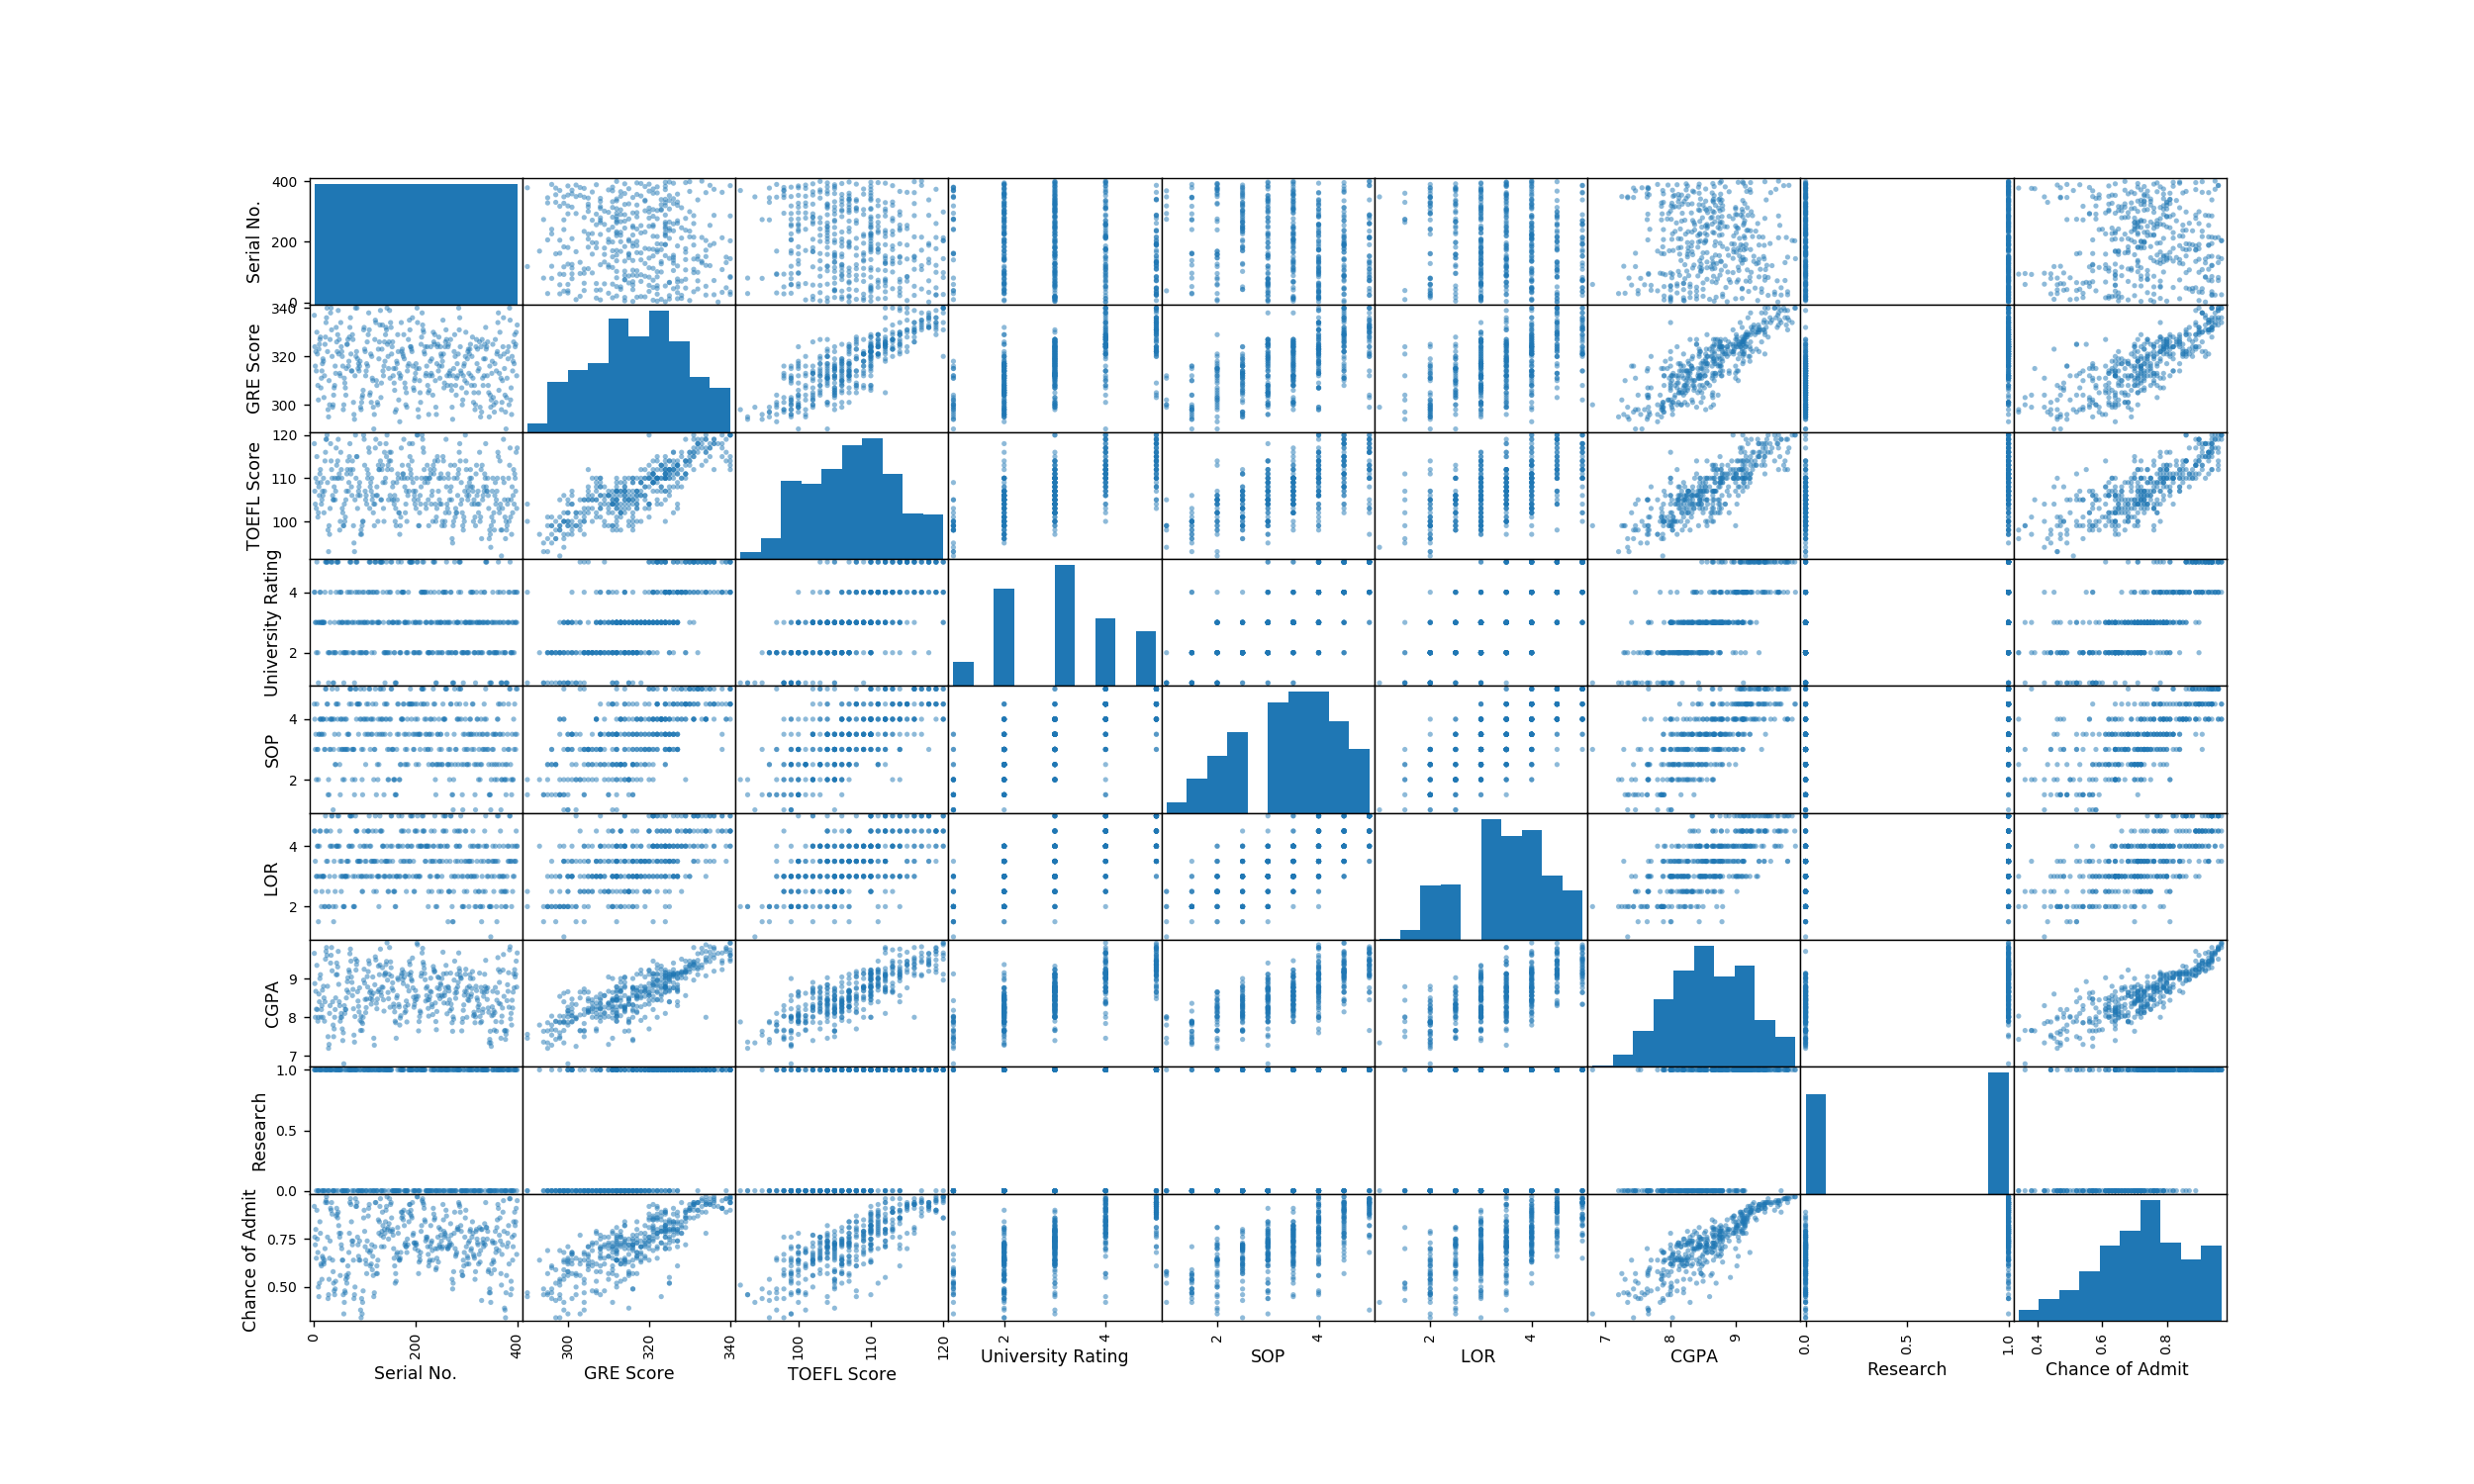

In [29]:
%matplotlib notebook
scatter_matrix(df, figsize=(20,12)) ;

#### Remark 1

Looking at the correlation chart we see that all variables, except for "Serial No.", have some impact on "Chance of Admit" variable. Variables like "GRE Score", "TOEFL Score" and "CGPA" are highly correlated to "Chance of Admit", while the rest not so much.

One could also draw the "correlation heatmap" to see this (use the "seaborn.heatmap" method)

#### Remark 2

An import issue that should be discussed is the high multicollinearity between the variables "GRE Score", "TOEFL Score" and "CGPA".

In this notebook all regressors are built using all the features. However, many variations with less features were also tested; no of them yielding better test/generalization scores though.

#### Remark 3

In odrer to treat the multicollinearity issue better, the next version of this notebook will contain also Ridge regressor, Lasso regressor and GAM regressor.

#### Defining the data variables

In [5]:
X = df.drop(df.iloc[:, [0,-1]], axis=1) # all columns except for the first and the last one
y = df[df.columns[-1]] 

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.1 , random_state = 0)

In [7]:
X_train.shape

(360, 7)

### 2. RNN regressor

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

#### preparing the data to feed them into the network

In [9]:
X_train_rnn = np.reshape( X_train.values, (X_train.values.shape[0],1,X_train.values.shape[1]) )
X_test_rnn = np.reshape( X_test.values,  (X_test.values.shape[0],1,X_test.values.shape[1]) )

In [10]:
y_train_rnn = y_train.values
y_test_rnn = y_test.values

#### tuning the network's hyperparameters

In [ ]:
best_score = 1

for rnn_units in [512,256,128,64]:
    for hidden_dense_layers in [1,2]:
        for dense_units in [64,32,16,8]:
            for act_fct in ['linear', 'tanh', 'sigmoid']:
                
                model_scores = []
                
                kf = KFold(n_splits=5, random_state=None, shuffle=False)
                cross_val_indices = kf.split(X_train_rnn)

                for tr_index, val_index in cross_val_indices:

                    X_tr, X_val = X_train_rnn[tr_index], X_train_rnn[val_index]
                    y_tr, y_val = y_train_rnn[tr_index], y_train_rnn[val_index]
                
                    model = Sequential()
                    # input layer
                    model.add(SimpleRNN(units = rnn_units, return_sequences=True, input_shape = (1,X_train_rnn.shape[2]) )) 
                    # hidden dense layers
                    if hidden_dense_layers == 1:
                        model.add(Dense(dense_units, activation = act_fct))
                    if hidden_dense_layers == 2:
                        model.add(Dense(dense_units, activation = act_fct))
                        model.add(Dense(dense_units, activation = act_fct))
                    # output layer
                    model.add(Dense(1, activation = 'linear'))

                    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

                    early_stopping = EarlyStopping(monitor='val_loss', min_delta= 0.001, patience=7, verbose=0, mode='auto')
                    
                    h=model.fit(X_tr, y_tr, epochs = 50, batch_size = 32,validation_data=(X_val, y_val), callbacks = [early_stopping] ) 
                    
                    #print(h.history['val_loss'][-1])
                    model_scores = np.append( model_scores, h.history['val_loss'][-1])

                # mean model score
                mean_model_score = np.mean(model_scores)
                
                if mean_model_score < best_score :
                    best_score = mean_model_score
                    opt_parameters = {'rnn_units' : rnn_units, 'hidden_dense_layers' : hidden_dense_layers,'dense_units' : dense_units, 'activation_function' : act_fct}

NOTE !!! The output of the cell above contains all the training results per epoch of all the trained networks used in the tuning procedure.
In the interest of space I chose to clear the output after running the cell.


In [12]:
print(opt_parameters)
print(best_score)

{'rnn_units': 256, 'hidden_dense_layers': 1, 'dense_units': 64, 'activation_function': 'sigmoid'}
0.008540483067433038


#### the final model

In [13]:
final_model = Sequential()
final_model.add(SimpleRNN(units = opt_parameters['rnn_units'], return_sequences=True, input_shape = (1,X_train_rnn.shape[2]) ))
final_model.add(Dense(opt_parameters['dense_units'], activation = opt_parameters['activation_function'] ))
final_model.add(Dense(1, activation = 'linear' ))
final_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
h = final_model.fit(X_train_rnn, y_train_rnn, epochs = 50, batch_size = 32, validation_data=(X_test_rnn, y_test_rnn) ) 

NOTE !!! The output of the cell above contains all the training results per epoch of the final model. In the interest of space I chose to clear the output after running the cell.

#### plots of training and test loss

<IPython.core.display.Javascript object>


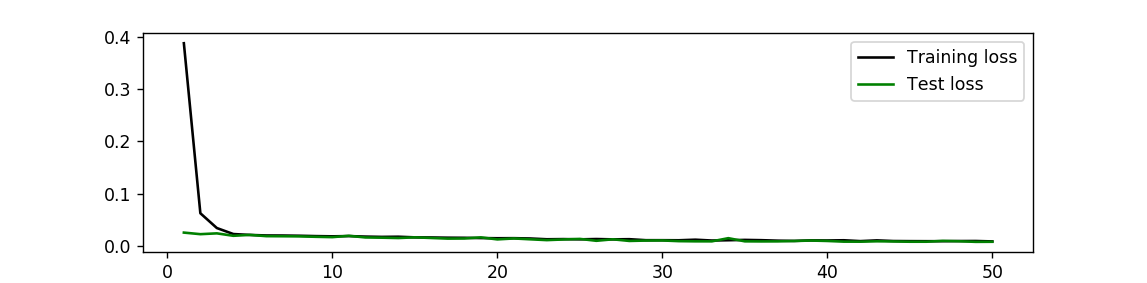

In [15]:
loss = h.history['loss']
test_loss = h.history['val_loss']

%matplotlib notebook

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss,'black', label='Training loss')
plt.plot(epochs, test_loss, 'green', label='Test loss')
plt.legend()
plt.show()

#### mse

In [27]:
final_rnn_model_train_set_mse = np.mean((y_train_rnn - final_model.predict(X_train_rnn))**2)
final_rnn_model_test_set_mse = h.history['val_loss'][-1]
final_rnn_model_distance = np.abs(final_rnn_model_test_set_mse - final_rnn_model_train_set_mse)

### 3. Linear OLS regression

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### mse

In [18]:
lin_reg_train_set_mse = np.mean((y_train - lin_reg.predict(X_train))**2)
lin_reg_test_set_mse = np.mean((y_test - lin_reg.predict(X_test))**2)
lin_reg_distance = np.abs(lin_reg_test_set_mse - lin_reg_train_set_mse)

### 4. k-Neighbors Regression

In [19]:
X_train_kNN = X_train.values
X_test_kNN = X_test.values

In [20]:
y_train_kNN = y_train.values
y_test_kNN = y_test.values

#### hyperparameters tuning

In [21]:
from sklearn.neighbors import KNeighborsRegressor

best_score = 1

metrics =  ['minkowski','chebyshev','manhattan','cosine']
neighbors = np.arange(1,36)

for metric in metrics :

    for n_neighbors in neighbors :  
        
        model_scores = []
        
        kf = KFold(n_splits=5, random_state=None, shuffle=False)
        cross_val_indices = kf.split(X_train_kNN)

        for tr_index, val_index in cross_val_indices:

            X_tr, X_val = X_train_kNN[tr_index], X_train_kNN[val_index]
            y_tr, y_val = y_train_kNN[tr_index], y_train_kNN[val_index]
            
            reg = KNeighborsRegressor(n_neighbors = n_neighbors, metric = metric)
            
            reg.fit(X_tr,y_tr)
            
            y_pred = reg.predict(X_val)
            val_mse = np.mean((y_val - y_pred)**2)
            
            model_scores = np.append(model_scores, val_mse)
        
        mean_model_score = np.mean(model_scores)
        
        if mean_model_score < best_score :
            best_score = mean_model_score
            best_parameters = {'n_neighbors' : n_neighbors,'metric' : metric}

print('The final Nearest Neighbors model is the one with ', best_parameters)

The final Nearest Neighbors model is the one with  {'n_neighbors': 15, 'metric': 'manhattan'}


#### the final model

In [22]:
f_NearNeigh = KNeighborsRegressor(n_neighbors = best_parameters['n_neighbors'], metric = best_parameters['metric'])

# train on the whole train set
f_NearNeigh.fit(X_train_kNN, y_train_kNN)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

#### mse

In [23]:
Near_Neigh_train_set_mse = np.mean((y_train_kNN - f_NearNeigh.predict(X_train_kNN))**2)
Near_Neigh_test_set_mse = np.mean((y_test_kNN - f_NearNeigh.predict(X_test_kNN))**2)
Near_Neigh_distance = np.abs(Near_Neigh_test_set_mse - Near_Neigh_train_set_mse)

### 5. Summary / Models comparisons

In [28]:
print('Rnn regressor')
print('train set MSE : ',final_rnn_model_train_set_mse )
print('test set MSE : ',final_rnn_model_test_set_mse )
print('distance : ', final_rnn_model_distance)

print('----------------------------------')

print('Linear OLS regressor')
print('train set MSE :', lin_reg_train_set_mse)
print('test set MSE : ', lin_reg_test_set_mse)
print('distance : ', lin_reg_distance)

print('----------------------------------')

print('Nearest Neighbors regressor')
print('train MSE : ',Near_Neigh_train_set_mse )
print('test MSE : ', Near_Neigh_test_set_mse)
print('distance : ', Near_Neigh_distance )

Rnn regressor
train set MSE :  0.031625269977668194
test set MSE :  0.008148161321878433
distance :  0.02347710865578976
----------------------------------
Linear OLS regressor
train set MSE : 0.0038484615186509885
test set MSE :  0.00529054916733843
distance :  0.0014420876486874413
----------------------------------
Nearest Neighbors regressor
train MSE :  0.00462971975308642
test MSE :  0.005823955555555556
distance :  0.0011942358024691364


First we observe is that the Rnn performs much worse on the training set than the other two models. Consequently, we can skip this model.

Among the other two regressors, the k-NN regressor seems to perform a bit better in total since the distance is smaller.
However, the differences between the two regressors are subtle.